In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-sampled/train_df_sample.pkl


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🔥 OptBinning 라이브러리를 활용한 신용평가 모델 개발</p>

> #### 데이터를 불러와 전처리하는 과정은 이전과 동일합니다. 다만 임의로 설명 변수를 선택하기 때문에 선택된 설명 변수는 다를 수 있습니다.

In [2]:
import warnings
warnings.filterwarnings('ignore', module='sklearn.metrics.cluster')

In [3]:
df = pd.read_pickle('/kaggle/input/amex-data-sampled/train_df_sample.pkl')

> ##### 💡 데이터는 위에서 프린트된 경로를 사용해야 합니다

In [4]:
def drop_null_cols(df, threshold=0.8):
    """
    데이터프레임에서 결측치 비율이 threshold 이상인 변수를 제거하는 함수
    """
    null_percent = df.isnull().mean()
    drop_cols = list(null_percent[null_percent >= threshold].index)
    df = df.drop(drop_cols, axis=1)
    print(f"Dropped {len(drop_cols)} columns: {', '.join(drop_cols)}")
    return df

In [5]:
df = df.reset_index()
import hashlib

def encode_customer_id(id_str):
    encoded_id = hashlib.sha256(id_str.encode('utf-8')).hexdigest()[:16]
    return encoded_id

df['customer_ID'] = df['customer_ID'].apply(encode_customer_id)
df = drop_null_cols(df)

Dropped 106 columns: D_49_mean, D_49_std, D_49_min, D_49_max, D_49_last, D_73_mean, D_73_std, D_73_min, D_73_max, D_73_last, D_76_mean, D_76_std, D_76_min, D_76_max, D_76_last, R_9_mean, R_9_std, R_9_min, R_9_max, R_9_last, B_29_mean, B_29_std, B_29_min, B_29_max, B_29_last, D_87_mean, D_87_std, D_87_min, D_87_max, D_87_last, D_88_mean, D_88_std, D_88_min, D_88_max, D_88_last, D_106_mean, D_106_std, D_106_min, D_106_max, D_106_last, R_26_mean, R_26_std, R_26_min, R_26_max, R_26_last, D_108_mean, D_108_std, D_108_min, D_108_max, D_108_last, D_110_mean, D_110_std, D_110_min, D_110_max, D_110_last, D_111_mean, D_111_std, D_111_min, D_111_max, D_111_last, B_39_mean, B_39_std, B_39_min, B_39_max, B_39_last, B_42_mean, B_42_std, B_42_min, B_42_max, B_42_last, D_132_mean, D_132_std, D_132_min, D_132_max, D_132_last, D_134_mean, D_134_std, D_134_min, D_134_max, D_134_last, D_135_mean, D_135_std, D_135_min, D_135_max, D_135_last, D_136_mean, D_136_std, D_136_min, D_136_max, D_136_last, D_137_me

In [6]:
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]

In [7]:
import random

num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if 'target' not in col and col not in cat_features]
num_cols_sample = random.sample([col for col in num_cols if 'target' not in col], 100)

In [8]:
feature_list = num_cols_sample + cat_features
all_list = feature_list + ['target']

In [9]:
df = df[all_list]

In [10]:
import gc
gc.collect()

50

In [11]:
for categorical_feature in cat_features:
    if df[categorical_feature].dtype == 'float16':
        df[categorical_feature] = df[categorical_feature].astype(str)
    if df[categorical_feature].dtype == 'category':
        df[categorical_feature] = df[categorical_feature].astype(str)    
    elif df[categorical_feature].dtype == 'object':
        df[categorical_feature] = df[categorical_feature].astype(str)

In [12]:
from sklearn.preprocessing import LabelEncoder

le_encoder = LabelEncoder()

for categorical_feature in cat_features:
    df[categorical_feature].fillna(value='NaN', inplace=True)
    df[categorical_feature] = le_encoder.fit_transform(df[categorical_feature])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
from sklearn.impute import SimpleImputer

def impute_nan(df, num_cols, strategy='mean'):
    """
    NaN 값을 strategy에 따라 num_cols에 대해 impute하는 함수
    
    :param df: DataFrame
    :param num_cols: list, imputation 대상 numeric column 리스트
    :param strategy: str, imputation 전략 (default: 'mean')
    :return: DataFrame, imputed DataFrame
    """
    imputer = SimpleImputer(strategy=strategy)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    return df

In [14]:
df = impute_nan(df,num_cols_sample, strategy="mean")

In [15]:
df.head()

,S_16_min,D_83_last,D_71_last,D_69_std,S_15_std,D_72_max,D_39_min,D_53_std,D_80_last,D_42_mean,...,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_68_last,target
0,0.001297,0.003130,0.007320,0.127469,0.056015,0.004601,0.000727,0.040835,0.002068,0.322754,...,4,0,0,0,1,1,1,3,5,1
1,0.001362,0.004456,0.631348,0.002574,0.039192,0.009041,0.004951,0.040835,0.007298,0.179873,...,2,0,0,4,0,1,0,3,6,0
2,0.007290,0.038784,0.011642,0.127469,0.098528,0.009087,0.000104,0.040835,0.005264,0.012764,...,0,2,2,7,2,0,1,4,7,0
3,0.000433,0.008568,0.005653,0.001978,0.027753,0.009895,0.000043,0.040835,0.206421,0.179873,...,1,1,0,5,0,1,1,1,6,0
4,0.001674,0.005787,0.092896,0.003036,0.078837,0.009712,0.004486,0.040835,0.002270,0.179873,...,1,1,0,0,0,1,0,2,6,0


In [16]:
import plotly.express as px

fig2 = px.pie(df, names='target', 
             height=400, width=600, 
             hole=0.7, 
             title='target class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

# optbinning library 설치

In [17]:
%pip install optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 55.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 79.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.6/298.6 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
te

> #### !pip install은 Python 환경에서 패키지를 설치하기 위한 표준적인 방법이며, %pip install은 IPython 환경에서 제공되는 패키지 관리 명령어입니다. 일반적으로 Jupyter Notebook에서는 !pip install이 더 일반적으로 사용되며, %pip install은 특정한 경우에 사용될 수 있습니다.

In [18]:
from optbinning import BinningProcess

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

Binning Process는 데이터셋의 변수들을 이진, 연속형 또는 다중 클래스 타겟 데이터 유형을 기반으로 최적의 구간화(bin)을 계산하기 위한 프로세스입니다.

매개변수:

* variable_names (array-like): 변수 이름의 리스트입니다.
* max_n_prebins (int, default=20): Pre-binning(사전 구간화) 후의 최대 구간 수입니다.
* min_prebin_size (float, default=0.05): 각 Pre-bin에 대한 최소 레코드 수의 비율입니다.
* min_n_bins (int 또는 None, optional, default=None): 최소 구간 수입니다. None인 경우, min_n_bins은 [0, max_n_prebins] 범위의 값입니다.
* max_n_bins (int 또는 None, optional, default=None): 최대 구간 수입니다. None인 경우, max_n_bins은 [0, max_n_prebins] 범위의 값입니다.
* min_bin_size (float 또는 None, optional, default=None): 각 구간의 최소 레코드 수의 비율입니다. None인 경우, min_bin_size = min_prebin_size입니다.
* max_bin_size (float 또는 None, optional, default=None): 각 구간의 최대 레코드 수의 비율입니다. None인 경우, max_bin_size = 1.0입니다.
* max_pvalue (float 또는 None, optional, default=None): 구간 간의 최대 p-value입니다.
* max_pvalue_policy (str, optional, default="consecutive"): p-value 조건을 만족하지 않는 구간을 결정하는 방법입니다. "consecutive"는 연속된 구간을 비교하고, "all"은 모든 구간을 비교합니다.
* selection_criteria (dict 또는 None, optional, default=None): 변수 선택 기준입니다. 자세한 내용은 참고 사항을 참조하세요.
* fixed_variables (array-like 또는 None, optional, default=None): 고정할 변수의 리스트입니다. 선택 기준을 만족하지 않을 경우에도 이러한 변수를 유지합니다.
* special_codes (array-like 또는 None, optional, default=None): 특별한 코드의 리스트입니다. 이러한 코드를 사용하여 따로 처리해야 하는 데이터 값을 지정할 수 있습니다.
* split_digits (int 또는 None, optional, default=None): 분할 지점의 유효 숫자 자릿수입니다. split_digits가 0으로 설정되면 분할 지점은 정수로 처리됩니다. None인 경우, 분할 지점의 모든 유효 숫자 자릿수가 고려됩니다.
* categorical_variables (array-like 또는 None, optional, default=None): 범주형 변수로 간주할 수치 변수의 리스트입니다. 이는 명목 변수입니다. 타겟 유형이 다중 클래스인 경우에는 해당되지 않습니다.
* binning_fit_params (dict 또는 None, optional, default=None): 특정 변수에 대한 최적

In [19]:
selection_criteria = {
    "iv": {"min": 0.025, "max": 0.7, "strategy": "highest", "top": 20},
    "quality_score": {"min": 0.01}
}

> #### Feature Selection 프로세스를 간소화 할 수 있습니다. 조건을 정해두면 해당조건에 맞는 변수를 추출할 수 있습니다.

In [20]:
binning_process = BinningProcess(feature_list,
                                 categorical_variables=cat_features,
                                 selection_criteria=selection_criteria)

In [21]:
X = df[feature_list]
y = df['target']

In [22]:
binning_process.fit(X, y)

BinningProcess(categorical_variables=['B_30_last', 'B_38_last', 'D_114_last',
                                      'D_116_last', 'D_117_last', 'D_120_last',
                                      'D_126_last', 'D_63_last', 'D_64_last',
                                      'D_68_last'],
               selection_criteria={'iv': {'max': 0.7, 'min': 0.025,
                                          'strategy': 'highest', 'top': 20},
                                   'quality_score': {'min': 0.01}},
               variable_names=['S_16_min', 'D_83_last', 'D_71_last', 'D_69_std',
                               'S_15_std', 'D_72_max', 'D_39_min', 'D_53_std',
                               'D_80_last', 'D_42_mean', 'P_3_last', 'S_27_min',
                               'D_92_last', 'R_8_mean', 'B_16_max', 'B_14_last',
                               'B_18_min', 'B_12_mean', 'D_145_max', 'D_60_min',
                               'D_94_mean', 'S_11_max', 'S_8_last', 'D_56_max',
                               'R_18_min', 'R_22_mean', 'B_22_max', 'B_2_last',
                               'R_7_mean', 'B_8_std', ...])

In [23]:
binning_process.information(print_level=2)

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    selection_criteria                   yes   * U
    fixed_variables                       no   * d
    categorical_variables                yes   * U
    special_codes                         no   * d
    split_digits                          no   * d
    binning_fit_params                    no   * d
    binning_transform_params              no   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                 1000

In [24]:
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,S_16_min,numerical,OPTIMAL,False,8,0.031068,0.003829,0.067525,0.000276
1,D_83_last,numerical,OPTIMAL,False,7,0.028932,0.003555,0.051478,0.015644
2,D_71_last,numerical,OPTIMAL,False,8,0.36866,0.041046,0.256362,0.686777
3,D_69_std,numerical,OPTIMAL,False,9,0.076311,0.009354,0.111078,0.03312
4,S_15_std,numerical,OPTIMAL,True,10,0.673314,0.079021,0.428676,0.619798
...,...,...,...,...,...,...,...,...,...
105,D_120_last,categorical,OPTIMAL,False,2,0.263812,0.032023,0.21299,0.358816
106,D_126_last,categorical,OPTIMAL,False,2,0.018833,0.002349,0.058528,0.036601
107,D_63_last,categorical,OPTIMAL,False,3,0.044258,0.005484,0.083182,0.08972
108,D_64_last,categorical,OPTIMAL,False,3,0.209134,0.025906,0.232605,0.563629


> #### 선택된 변수만 보고싶다면 아래 코드를 참조해주세요.


In [27]:
summary = binning_process.summary()

selected_summary = summary[summary["selected"] == True]

In [28]:
selected_summary

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
4,S_15_std,numerical,OPTIMAL,True,10,0.673314,0.079021,0.428676,0.619798
5,D_72_max,numerical,OPTIMAL,True,8,0.441648,0.049209,0.235252,0.142107
7,D_53_std,numerical,OPTIMAL,True,3,0.697978,0.074455,0.346512,0.344178
9,D_42_mean,numerical,OPTIMAL,True,3,0.552934,0.060103,0.253586,0.294292
11,S_27_min,numerical,OPTIMAL,True,11,0.499413,0.05941,0.342462,0.240385
19,D_60_min,numerical,OPTIMAL,True,14,0.405603,0.048967,0.338237,0.907759
22,S_8_last,numerical,OPTIMAL,True,11,0.463368,0.054082,0.343112,0.679681
23,D_56_max,numerical,OPTIMAL,True,5,0.37716,0.044133,0.290175,0.749354
32,S_27_std,numerical,OPTIMAL,True,9,0.514205,0.061807,0.385342,0.045074
33,D_60_std,numerical,OPTIMAL,True,14,0.372376,0.04486,0.330698,0.417736


In [29]:
optb = binning_process.get_binned_variable("D_42_mean")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.04)",6625,0.06625,5964,661,0.099774,1.157254,0.064008,0.007582
1,"[0.04, 0.18)",84662,0.84662,65719,18943,0.223749,0.201464,0.032677,0.004078
2,"[0.18, inf)",8713,0.08713,2250,6463,0.741765,-2.097653,0.456250,0.048443
3,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,100000,1.00000,73933,26067,0.260670,,0.552934,0.060103


> #### 임의로 변수를 선택하기 때문에 위 변수가 없다면 에러가 날 수 있습니다. 확인 후 실행 바랍니다.

> #### 📊 구간화 그래프를 살펴봅시다. binning_table.plot()을 사용하면 쉽게 그래프를 그릴 수 있습니다.

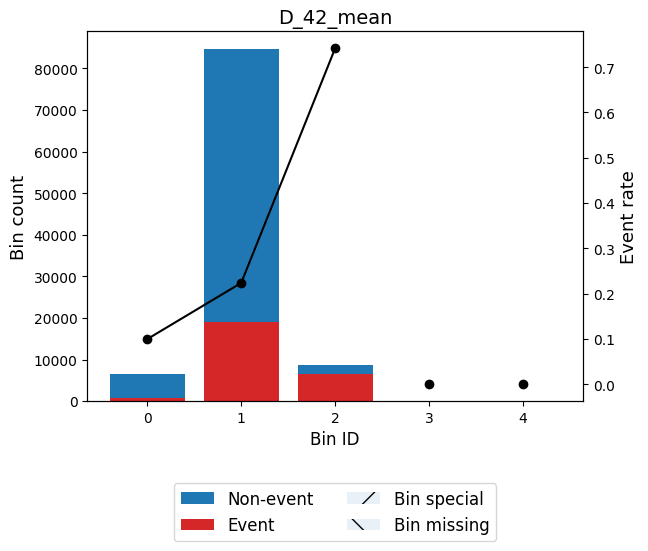

In [30]:
optb.binning_table.plot(metric="event_rate")

> #### 위 변수 같은 경우는, 2 구간에서 불량율이 매우 높게 나타납니다. 이벤트 발생 확률 또한 단조증가함을 알 수 있습니다. 일반적으로 구간화는 이벤트 발생 확률이 단조 증가하면 좋다고 판단합니다.

> ##### optb.binning_table.plot(metric="event_rate")에서 metric은 그래프를 그릴 때 사용할 메트릭(metric)을 지정하는 매개변수입니다. 이 메트릭은 각 구간(bin)의 값을 기준으로 그래프를 그릴 때 사용됩니다. 예를 들어, "event_rate"를 지정하면 각 구간의 이벤트 발생 비율을 기준으로 그래프를 그립니다.

> ##### optb.binning_table.plot()은 optbinning 패키지에서 사용되는 BinningTable 객체의 메서드입니다. BinningTable 객체는 변수의 구간(bin) 정보를 저장하고 분석 결과를 시각화할 수 있는 기능을 제공합니다. 이를 통해 각 구간의 특성을 시각적으로 확인하고 모델 개발에 유용한 통찰력을 얻을 수 있습니다. plot() 메서드를 사용하여 구간별 메트릭에 대한 그래프를 생성하고 시각화할 수 있습니다. metric 매개변수를 적절히 설정하여 원하는 메트릭에 대한 그래프를 생성할 수 있습니다.

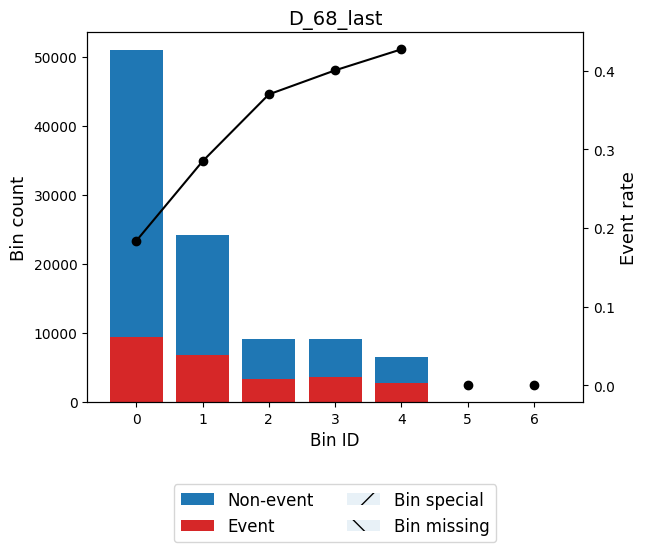

In [31]:
optb = binning_process.get_binned_variable("D_68_last")
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate")

> #### 어떤 변수들이 선택되었는지 살펴봅시다.

In [32]:
binning_process.get_support(names=True)

array(['S_15_std', 'D_72_max', 'D_53_std', 'D_42_mean', 'S_27_min',
       'D_60_min', 'S_8_last', 'D_56_max', 'S_27_std', 'D_60_std',
       'B_14_min', 'B_9_std', 'D_46_mean', 'B_8_mean', 'R_27_mean',
       'B_14_mean', 'D_45_min', 'B_4_std', 'D_43_min', 'S_7_std'],
      dtype='<U13')

> #### 이전 노트북에서 직접 IV와 WOE함수를 만들어 데이터를 변환했던 것을 기억하시나요? 이 작업을 OptBinning을 사용하면 한줄의 코드로 실행 가능합니다. 아래 코드를 살펴보시죠.

In [33]:
X_transform = binning_process.transform(X, metric="woe")

In [34]:
X_transform

,S_15_std,D_72_max,D_53_std,D_42_mean,S_27_min,D_60_min,S_8_last,D_56_max,S_27_std,D_60_std,B_14_min,B_9_std,D_46_mean,B_8_mean,R_27_mean,B_14_mean,D_45_min,B_4_std,D_43_min,S_7_std
0,0.434330,-0.188926,0.505220,-2.097653,-0.295482,-0.432574,-0.807160,-0.473004,-1.298719,-0.602993,-0.249766,-0.251836,0.260046,-0.719002,-0.311917,-0.348928,-0.973384,1.258563,0.249041,-1.359771
1,1.082455,0.242904,0.505220,0.201464,-0.517691,-0.432574,1.331986,-0.473004,0.651723,0.231757,-0.249766,1.083471,0.260046,0.915325,0.286515,-0.617697,1.037529,-0.762230,0.762795,-0.939858
2,-0.241592,0.242904,0.505220,1.157254,1.392727,-0.432574,-0.402995,-0.473004,1.155758,0.024387,-0.564960,-0.251836,0.260046,-0.719002,-0.311917,-0.348928,-0.973384,-0.294930,0.249041,0.312198
3,1.082455,0.276507,0.505220,0.201464,1.097997,-0.432574,1.805010,1.874151,0.651723,0.207575,-0.478164,0.094444,-0.481857,0.915325,0.286515,-0.348928,1.037529,0.518454,0.249041,1.362953
4,0.079997,0.276507,0.505220,0.201464,0.779002,-0.432574,1.571242,0.241453,0.651723,0.231757,-0.037214,0.950564,0.726675,0.915325,0.286515,-0.348928,1.207758,0.773110,0.249041,0.312198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.082455,0.276507,-2.567792,0.201464,1.097997,0.370092,0.606627,0.241453,0.651723,-0.286830,-0.978556,1.083471,0.726675,0.915325,0.286515,-0.617697,0.630770,0.518454,0.762795,-0.939858
99996,1.082455,0.276507,-0.475204,0.201464,0.779002,-0.662083,1.571242,-0.473004,0.651723,0.231757,-0.478164,1.083471,0.726675,0.915325,0.286515,-0.348928,1.037529,0.518454,0.547651,1.362953
99997,1.599766,0.349965,0.505220,0.201464,-0.378089,1.331526,-0.166673,0.241453,-0.474038,-0.453787,1.286951,0.094444,0.726675,0.830703,0.286515,1.449788,1.037529,-0.043612,0.547651,1.362953
99998,-0.585014,0.280506,0.505220,0.201464,-0.451609,1.117217,-0.106743,0.241453,-0.250381,0.024387,0.549325,0.188921,0.726675,0.640583,0.286515,0.605587,-0.311123,0.085070,0.249041,0.813254


> #### 기존 변수 값이 WOE 값으로 변환(transform)되었습니다. 이제 WOE값을 사용해 모델링을 진행하면 됩니다.

In [35]:
from sklearn.linear_model import LogisticRegression
from optbinning import Scorecard
from optbinning.scorecard import Counterfactual

binning_process = BinningProcess(feature_list,
                                 categorical_variables=cat_features,
                                 selection_criteria=selection_criteria)

estimator = LogisticRegression(solver="lbfgs")

scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

scorecard.fit(X, y)

Scorecard(binning_process=BinningProcess(categorical_variables=['B_30_last',
                                                                'B_38_last',
                                                                'D_114_last',
                                                                'D_116_last',
                                                                'D_117_last',
                                                                'D_120_last',
                                                                'D_126_last',
                                                                'D_63_last',
                                                                'D_64_last',
                                                                'D_68_last'],
                                         selection_criteria={'iv': {'max': 0.7,
                                                                    'min': 0.025,
                                                                    'strategy': 'highest',
                                                                    'top': 20},
                                                             'quality_score': {'min': 0.01}},
                                         variable_names=['S_16_min',
                                                         'D_83_last',
                                                         'D_71_last',...
                                                         'D_80_last',
                                                         'D_42_mean',
                                                         'P_3_last', 'S_27_min',
                                                         'D_92_last',
                                                         'R_8_mean', 'B_16_max',
                                                         'B_14_last',
                                                         'B_18_min',
                                                         'B_12_mean',
                                                         'D_145_max',
                                                         'D_60_min',
                                                         'D_94_mean',
                                                         'S_11_max', 'S_8_last',
                                                         'D_56_max', 'R_18_min',
                                                         'R_22_mean',
                                                         'B_22_max', 'B_2_last',
                                                         'R_7_mean', 'B_8_std', ...]),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

> #### 가장 간단한 로지스틱 회귀를 사용해보겠습니다. estimator에 XGBoost나 LighGBM을 사용해도 좋습니다.

> #### 스코어 카드를 바로 만들어 보겠습니다. 최저 점수는 300점, 최대 점수는 850점입니다.

In [38]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,R_27_max,"(-inf, 0.03)",-0.594784
1,R_27_max,"[0.03, 1.01)",28.321605
2,R_27_max,"[1.01, 1.01)",34.108601
3,R_27_max,"[1.01, 1.01)",34.651404
4,R_27_max,"[1.01, inf)",35.407918
...,...,...,...
8,B_26_std,"[0.00, 0.02)",32.338130
9,B_26_std,"[0.02, 0.04)",46.046439
10,B_26_std,"[0.04, inf)",46.570249
11,B_26_std,Special,30.939271


> #### 위에서 만든 스코어 카드 테이블을 살펴보겠습니다.

In [39]:
scorecard.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,R_27_max,0,"(-inf, 0.03)",7533,0.07533,1939,5594,0.742599,-2.102011,0.395965,0.042017,-0.468186,-0.594784
1,R_27_max,1,"[0.03, 1.01)",11249,0.11249,7923,3326,0.295671,-0.174490,0.003565,0.000445,-0.468186,28.321605
2,R_27_max,2,"[1.01, 1.01)",6503,0.06503,5059,1444,0.222051,0.211263,0.002753,0.000343,-0.468186,34.108601
3,R_27_max,3,"[1.01, 1.01)",24168,0.24168,18951,5217,0.215864,0.247445,0.013904,0.001734,-0.468186,34.651404
4,R_27_max,4,"[1.01, inf)",50547,0.50547,40061,10486,0.207450,0.297873,0.041578,0.005178,-0.468186,35.407918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,B_26_std,8,"[0.00, 0.02)",5003,0.05003,3578,1425,0.284829,-0.121857,0.000764,0.000095,0.358259,32.338130
9,B_26_std,9,"[0.02, 0.04)",5062,0.05062,2187,2875,0.567957,-1.316011,0.106218,0.012395,0.358259,46.046439
10,B_26_std,10,"[0.04, inf)",13916,0.13916,5857,8059,0.579118,-1.361641,0.313102,0.036369,0.358259,46.570249
11,B_26_std,11,Special,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000,0.358259,30.939271


> #### 보다 자세한 테이블은 위와 같습니다. WoE와 IV, JS 값까지 보여줍니다.

> ##### "JS Distance"는 각 구간(bin)의 신용 점수 분포 간의 거리(Distance)를 측정하는 지표입니다.

> ##### 스코어카드에서 "JS Distance"는 구간(bin)별로 신용 점수가 얼마나 다른지를 나타내는 지표로 사용됩니다. 구간별 신용 점수 분포가 서로 다를수록 "JS Distance"는 높아지며, 구간간의 분리도가 높음을 나타냅니다. 이는 스코어카드가 독립 변수의 변화에 따라 점수를 적절하게 조정하여 신용 등급을 산출할 수 있도록 도와줍니다.


In [37]:
sc = scorecard.table(style="summary")
sc.groupby("Variable").agg({'Points' : [np.min, np.max]}).sum()

Points  amin    300.0
        amax    850.0
dtype: float64

> #### 위 코드는 점수가 잘 나왔는지 검증하는 코드입니다.

> #### 📊 만든 스코어를 평가해봅시다.

In [38]:
y_pred = scorecard.predict_proba(X)[:, 1]

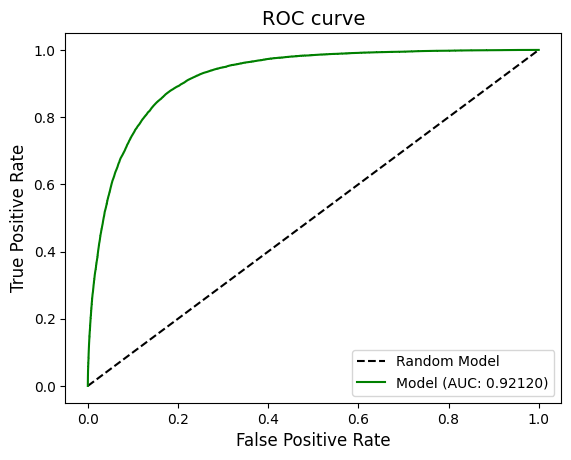

In [39]:
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
plot_auc_roc(y, y_pred)

> #### 단순한 모델을 사용하니 AUC가 이전보다 떨어진것을 확인할 수 있습니다. 하지만 데이터 전처리가 잘된 편이라 점수가 아주 낮진 않습니다.

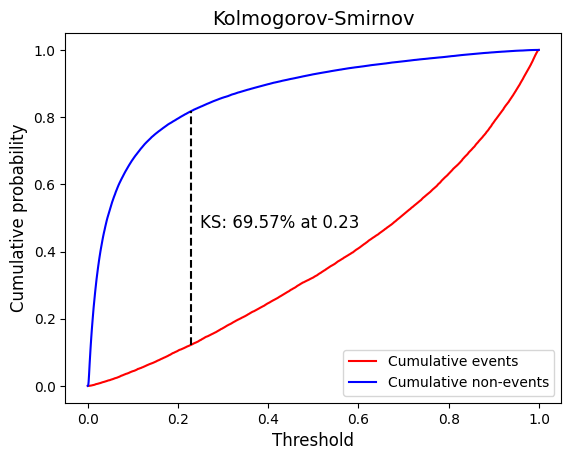

In [40]:
plot_ks(y, y_pred)

> #### KS 통계량도 간단한 함수로 계산하고 시각화할 수 있습니다.

> #### 📊 스코어 분포를 살펴보도록 하죠.

In [41]:
score = scorecard.score(X)

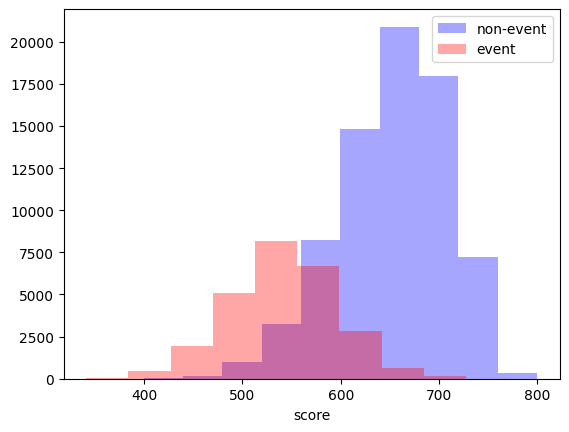

In [42]:
import matplotlib.pyplot as plt
mask = y == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">OptBinning 라이브러리를 사용한 모델 모니터링</p>

> #### PSI지표를 활용한 모델 드리프트 체크

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

> #### 훈련 데이터세트와 테스트 데이터세트를 분할해줍니다. 여기서 테스트 데이터세트는 우리가 보지 못한 데이터라고 가정합니다.

In [44]:
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['B_30_last',
                                                                'B_38_last',
                                                                'D_114_last',
                                                                'D_116_last',
                                                                'D_117_last',
                                                                'D_120_last',
                                                                'D_126_last',
                                                                'D_63_last',
                                                                'D_64_last',
                                                                'D_68_last'],
                                         selection_criteria={'iv': {'max': 0.7,
                                                                    'min': 0.025,
                                                                    'strategy': 'highest',
                                                                    'top': 20},
                                                             'quality_score': {'min': 0.01}},
                                         variable_names=['S_16_min',
                                                         'D_83_last',
                                                         'D_71_last',...
                                                         'D_80_last',
                                                         'D_42_mean',
                                                         'P_3_last', 'S_27_min',
                                                         'D_92_last',
                                                         'R_8_mean', 'B_16_max',
                                                         'B_14_last',
                                                         'B_18_min',
                                                         'B_12_mean',
                                                         'D_145_max',
                                                         'D_60_min',
                                                         'D_94_mean',
                                                         'S_11_max', 'S_8_last',
                                                         'D_56_max', 'R_18_min',
                                                         'R_22_mean',
                                                         'B_22_max', 'B_2_last',
                                                         'R_7_mean', 'B_8_std', ...]),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

In [45]:
from optbinning.scorecard import ScorecardMonitoring

monitoring = ScorecardMonitoring(scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=10, verbose=True)

In [46]:
monitoring.fit(X_test, y_test, X_train, y_train)

2023-05-16 15:36:17,613 | INFO : Monitoring started.
2023-05-16 15:36:17,614 | INFO : Options: check parameters.
2023-05-16 15:36:17,618 | INFO : System stability analysis started.
2023-05-16 15:36:18,440 | INFO : System stability analysis terminated. Time: 0.8209s
2023-05-16 15:36:18,441 | INFO : Variable analysis started.
2023-05-16 15:36:18,697 | INFO : Variable analysis terminated. Time: 0.2549s
2023-05-16 15:36:18,698 | INFO : Monitoring terminated. Time: 1.0845s


ScorecardMonitoring(psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(categorical_variables=['B_30_last',
                                                                                              'B_38_last',
                                                                                              'D_114_last',
                                                                                              'D_116_last',
                                                                                              'D_117_last',
                                                                                              'D_120_last',
                                                                                              'D_126_last',
                                                                                              'D_63_last',
                                                                                              'D_64_last',
                                                                                              'D_68_last'],
                                                                       selection_criteria={'iv': {'max': 0.7,
                                                                                                  'min': 0.025,
                                                                                                  'strategy': 'highest',
                                                                                                  'top': 20},
                                                                                           'quality_score': {'min': 0.01}},
                                                                       variabl...
                                                                                       'D_42_mean',
                                                                                       'P_3_last',
                                                                                       'S_27_min',
                                                                                       'D_92_last',
                                                                                       'R_8_mean',
                                                                                       'B_16_max',
                                                                                       'B_14_last',
                                                                                       'B_18_min',
                                                                                       'B_12_mean',
                                                                                       'D_145_max',
                                                                                       'D_60_min',
                                                                                       'D_94_mean',
                                                                                       'S_11_max',
                                                                                       'S_8_last',
                                                                                       'D_56_max',
                                                                                       'R_18_min',
                                                                                       'R_22_mean',
                                                                                       'B_22_max',
                                                                                       'B_2_last',
                                                                                       'R_7_mean',
                                                                                       'B_8_std', ...]),
                                        estimator=LogisticRegression(),
                                        scaling_method='min_max',


In [53]:
monitoring.psi_table()

,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,"(-inf, 494.60)",2907,6682,0.096900,0.095457,2.164594e-05
1,"[494.60, 523.48)",2526,6075,0.084200,0.086786,7.821037e-05
2,"[523.48, 542.64)",2127,4730,0.070900,0.067571,1.600550e-04
3,"[542.64, 559.66)",1999,4645,0.066633,0.066357,1.147169e-06
4,"[559.66, 579.94)",2495,5873,0.083167,0.083900,6.437924e-06
5,"[579.94, 591.95)",1540,3631,0.051333,0.051871,5.611158e-06
6,"[591.95, 605.12)",1764,4234,0.058800,0.060486,4.764731e-05
7,"[605.12, 616.97)",1845,4018,0.061500,0.057400,2.828708e-04
8,"[616.97, 637.52)",3280,7647,0.109333,0.109243,7.490241e-08
9,"[637.52, inf)",9517,22465,0.317233,0.320929,4.279459e-05


> #### 굉장히 안정적입니다. 그래프도 쉽게 그릴 수 있습니다.

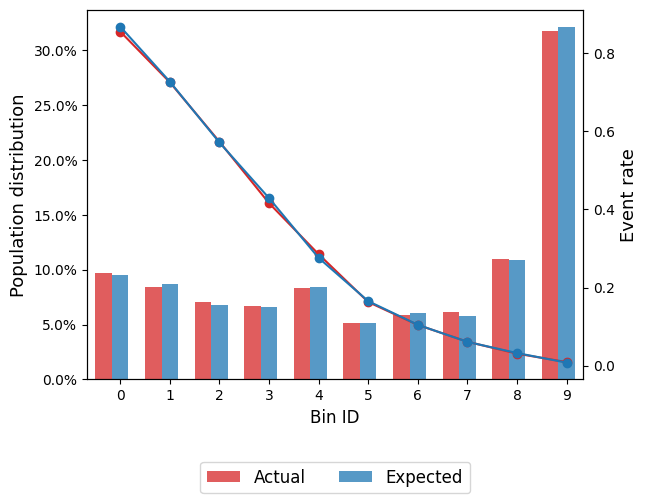

In [54]:
monitoring.psi_plot()

In [55]:
monitoring.tests_table()

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"(-inf, 494.60)",2907,6682,0.855521,0.868153,2.756439,0.096864
1,"[494.60, 523.48)",2526,6075,0.725653,0.727243,0.022703,0.880232
2,"[523.48, 542.64)",2127,4730,0.573578,0.571459,0.026913,0.869691
3,"[542.64, 559.66)",1999,4645,0.416208,0.429064,0.944999,0.330995
4,"[559.66, 579.94)",2495,5873,0.285371,0.276009,0.763286,0.382302
5,"[579.94, 591.95)",1540,3631,0.162987,0.165244,0.040056,0.841372
6,"[591.95, 605.12)",1764,4234,0.104308,0.104629,0.001369,0.970485
7,"[605.12, 616.97)",1845,4018,0.061247,0.060976,0.001620,0.967897
8,"[616.97, 637.52)",3280,7647,0.030793,0.032300,0.169198,0.680826
9,"[637.52, inf)",9517,22465,0.009142,0.007834,1.400466,0.236646


> ##### 이 통계적 검정은 이벤트 비율(카이제곱 검정 - 이진 타겟) 또는 평균(스튜던트 t-검정 - 연속 타겟)이 유의하게 다른지 여부를 결정하기 위해 수행됩니다. 귀무가설은 실제값(actual)이 예상값(expected)과 동일하다는 것입니다.

In [56]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0006 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0        0.0
    [0.05, 0.10)      1        0.1
    [0.10, 0.50)      3        0.3
    [0.50, 1.00)      6        0.6

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records   30000          -     70000            -
        Event records    7820   0.260667     18247     0.260671
    Non-event records   22180   0.739333     51753     0.739329

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.672251  0.673042   -0.000792
     True negative rate 0.921

> #### 시스템 리포트를 통해 확인할 수도 있습니다.

In [59]:
monitoring.psi_variable_table(style="summary")

,Variable,PSI
0,B_14_mean,0.000192
1,B_14_min,0.000202
2,B_4_std,0.000313
3,B_8_mean,0.000140
4,B_9_std,0.000925
5,D_127_std,0.000193
6,D_42_mean,0.000116
7,D_43_min,0.000206
8,D_45_min,0.000265
9,D_46_mean,0.000233


> #### 등급 뿐만 아니라 전체적인 변수의 안정성도 높습니다. 